In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from python import solar_utils as su
from python import utils as pu

In [2]:
%%time
# Get TGW input solar data
df = su.prepare_solar_data(
    climate_path = f"{pu.tgw_path}/historical_1980_2019/hourly/tgw_wrf_historical_hourly_2006*.nc",
    temperature_var = 'T2C',
    shortwave_var = 'SWDOWN',
    lat_name="south_north",
    lon_name="west_east",
    curvilinear=True,
)

CPU times: user 1min 16s, sys: 8.66 s, total: 1min 24s
Wall time: 1min 41s


In [3]:
# Get optimal beta
optimized_beta = su.optimize_beta(
    df = df,
    temperature_var = "T2C",
    shortwave_var = "SWDOWN"
)

In [4]:
# Get TGW correction factors
df = su.get_solar_correction_factors(
    df = df,
    temperature_var = 'T2C',
    shortwave_var = 'SWDOWN',
    beta = optimized_beta,
)

In [5]:
# Baseline
df['sim_power_norm_baseline'] = su.calculate_solar_power(df['SWDOWN'], df['T2C'])
np.mean((df['sim_power_norm_baseline'] - df['actual_power_norm'])**2)

np.float64(0.022178571219852727)

In [6]:
# Optimized beta plus bias-correction
np.mean((df['sim_power_norm_corrected'] - df['actual_power_norm'])**2)

np.float64(0.006351739390368432)

In [7]:
# Get unique locations
latlons = df[['sind_lat', 'sind_lon']].value_counts().index.unique()

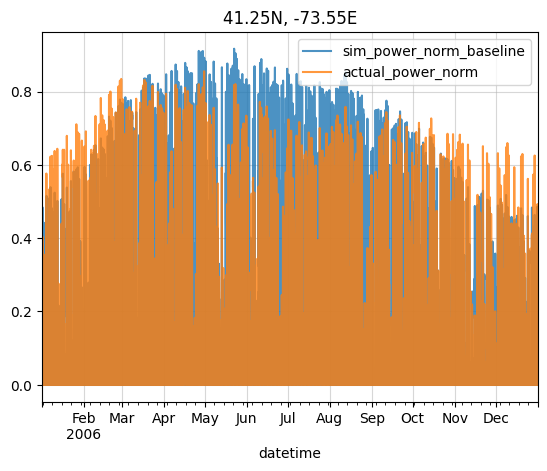

In [8]:
# Example plot
lat, lon = latlons[15]
fig, ax = plt.subplots()
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='sim_power_norm_baseline', ax=ax, alpha=0.8)
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='actual_power_norm', ax=ax, alpha=0.8)

ax.set_title(f"{lat}N, {lon}E")
ax.grid(alpha=0.5)

plt.show()

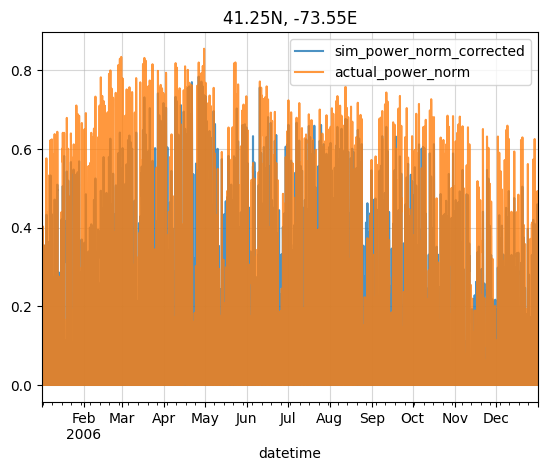

In [9]:
# Example plot
lat, lon = latlons[15]
fig, ax = plt.subplots()
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='sim_power_norm_corrected', ax=ax, alpha=0.8)
df[(df['sind_lat'] == lat) & (df['sind_lon'] == lon)].plot(x='datetime', y='actual_power_norm', ax=ax, alpha=0.8)

ax.set_title(f"{lat}N, {lon}E")
ax.grid(alpha=0.5)

plt.show()

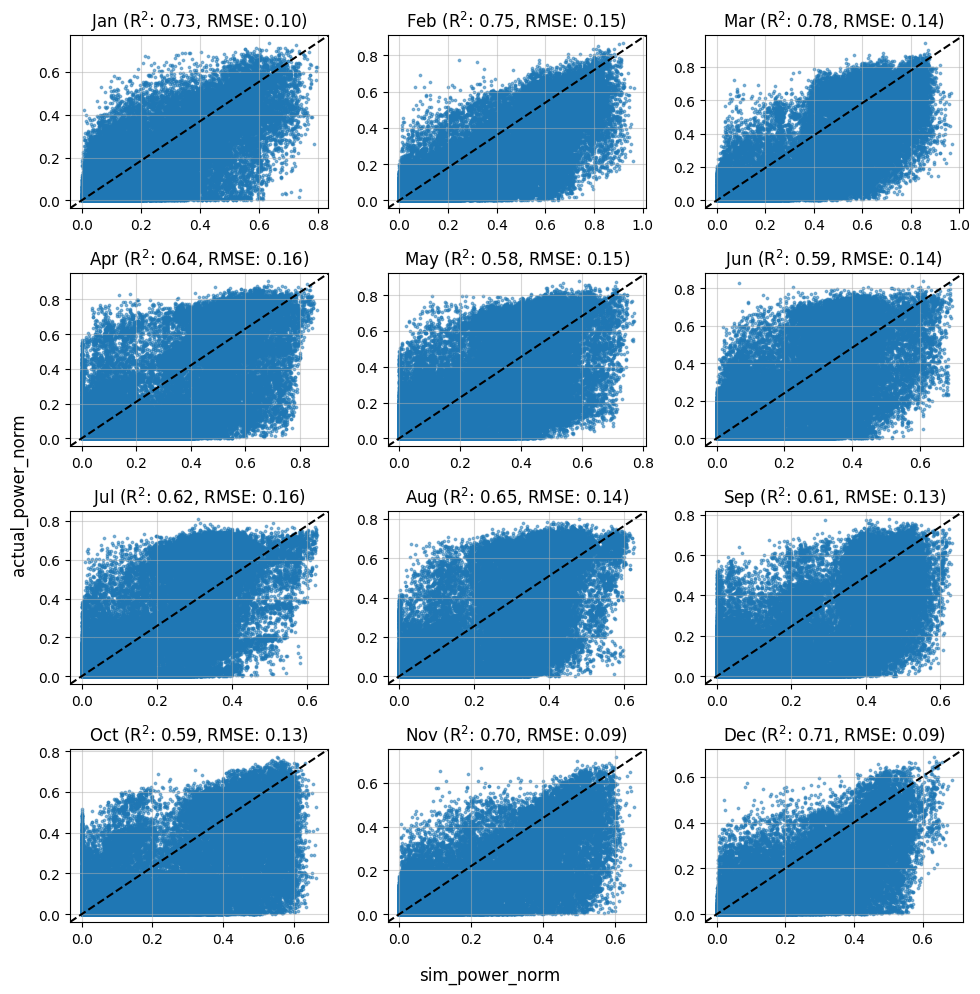

In [10]:
# Scatter
su.plot_solar_correction_fit(df,
                             x_col='sim_power_norm',
                             y_col='actual_power_norm')

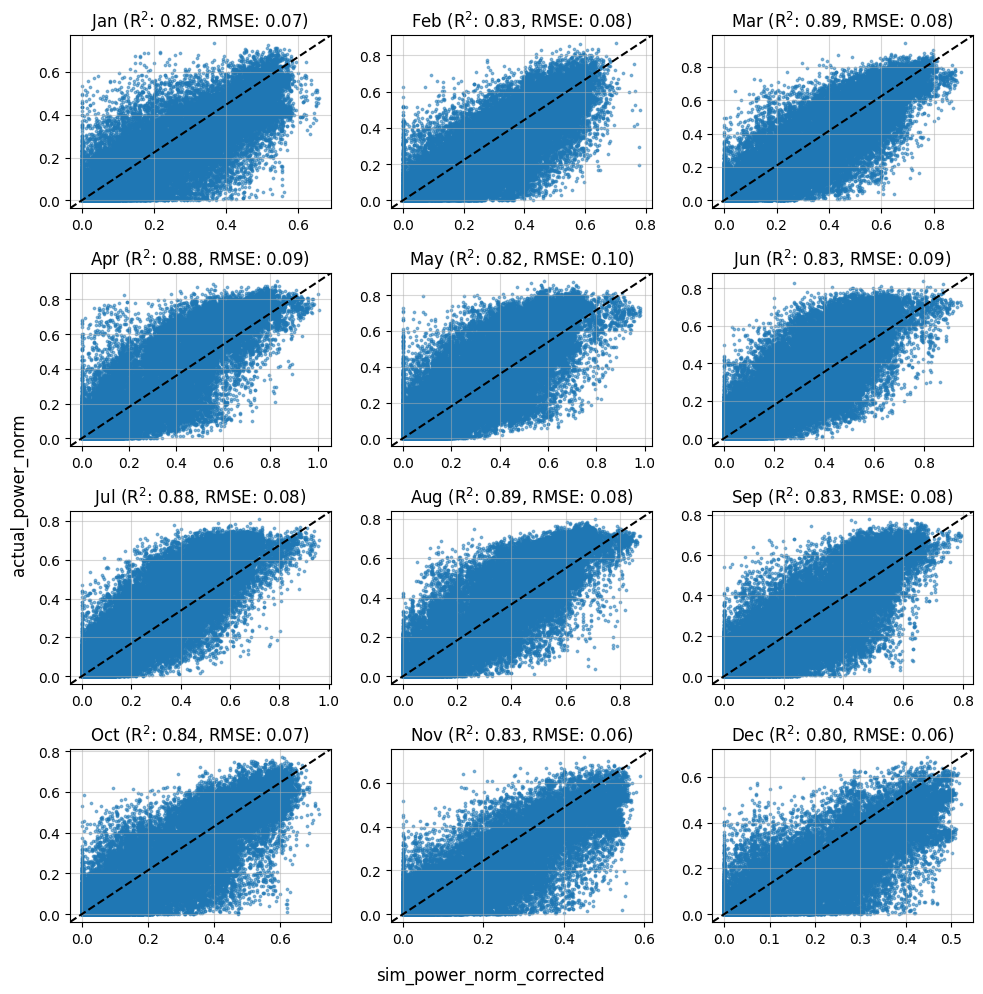

In [11]:
# Scatter
su.plot_solar_correction_fit(df, 
                             x_col='sim_power_norm_corrected', 
                             y_col='actual_power_norm')

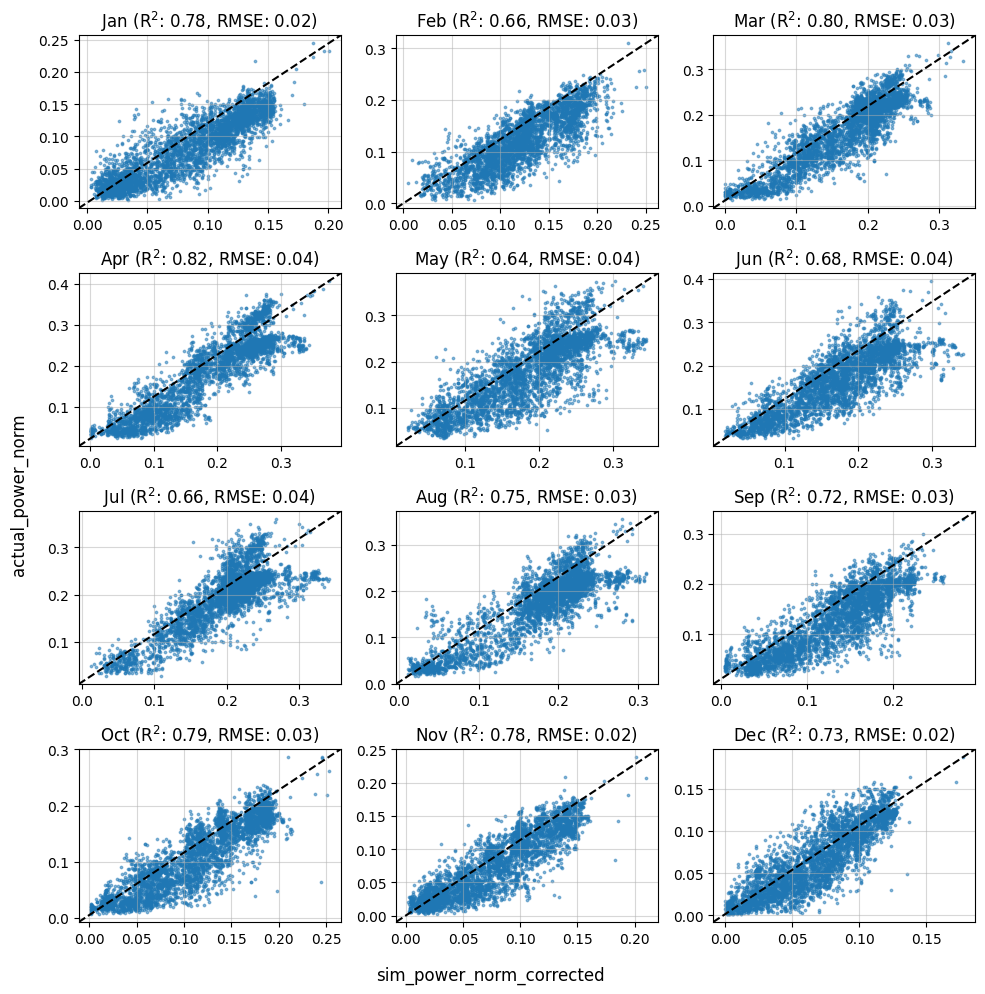

In [12]:
# Scatter
su.plot_solar_correction_fit(df,
                             x_col='sim_power_norm_corrected',
                             y_col='actual_power_norm',
                             daily=True)

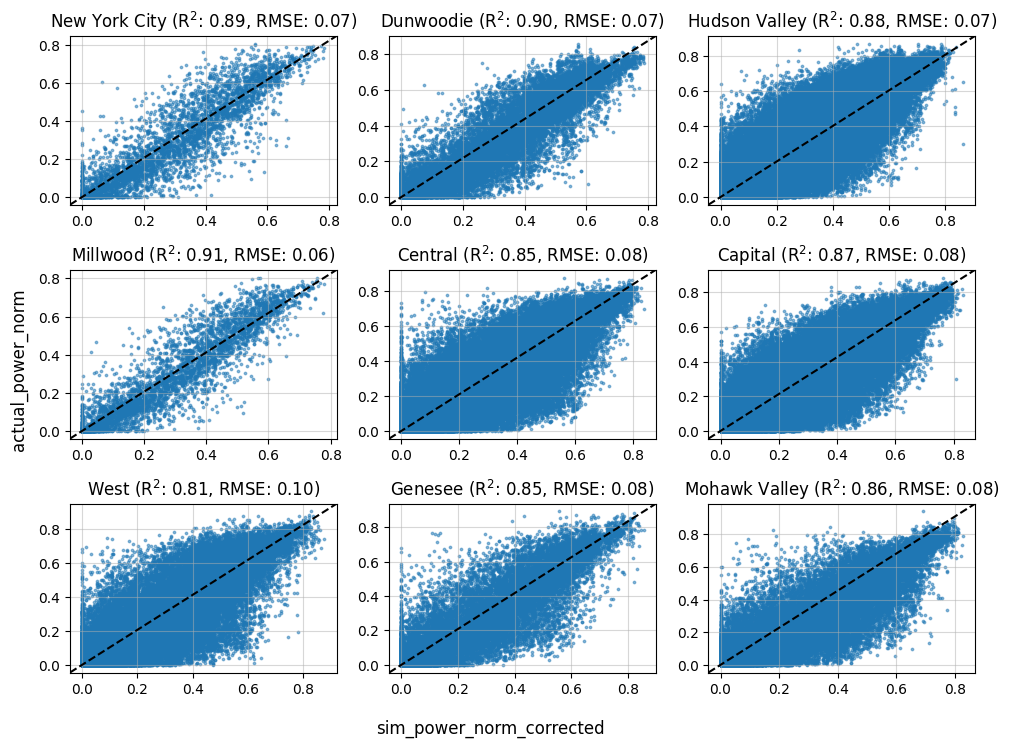

In [13]:
# Scatter
su.plot_solar_correction_fit(df,
                             x_col='sim_power_norm_corrected',
                             y_col='actual_power_norm',
                             zonal=True)

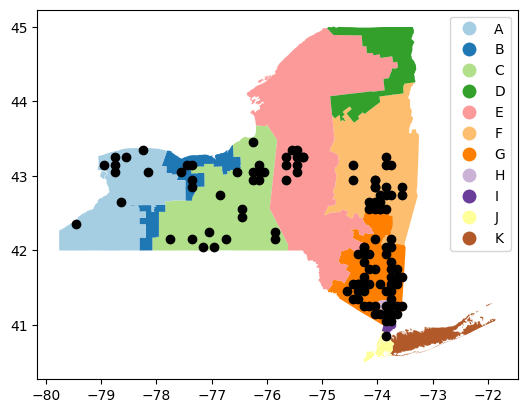

In [15]:
# Get all sites
gdf = su.merge_to_zones(df[(df['dayofyear'] == 1) & (df['hour'] == 12)])

# Load NYISO
nyiso_gdf = gpd.read_file(f"{pu.project_path}/data/nyiso/shapefiles/NYISO_Load_Zone_Dissolved.shp")

# Plot
fig, ax = plt.subplots()

nyiso_gdf.plot(column='ZONE', legend=True, cmap='Paired', ax=ax)
gdf['geometry'].plot(color='black', ax=ax)

plt.show()